## The sinusoidal embedding

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

In [2]:
frequencies = np.exp(
    np.linspace(
        np.log(1),
        np.log(1000),
        32 // 2,
    )
)

In [16]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    x = np.array(y)
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = np.concatenate(
        [np.sin(angular_speeds * x), np.cos(angular_speeds * x)]
    )
    embedding_list.append(embeddings)
embedding_array = np.transpose(embedding_list)

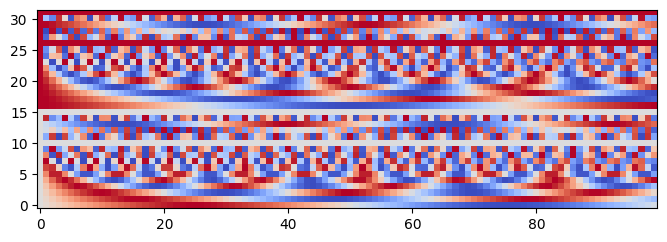

In [17]:
plt.figure(figsize=(8, 6))
plt.imshow(
    embedding_array, cmap="coolwarm", interpolation="nearest", origin="lower"
)

plt.show()

In [9]:
def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError(
            "Cannot use sin/cos positional encoding with "
            "odd dim (got dim={:d})".format(d_model)
        )
    pe = np.zeros((length, d_model))
    position = np.array(list([x] for x in np.arange(0, length)))
    div_term = np.exp(
        (np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    )
    pe[:, : d_model // 2] = np.sin(position * div_term)
    pe[:, d_model // 2 :] = np.cos(position * div_term)

    return pe

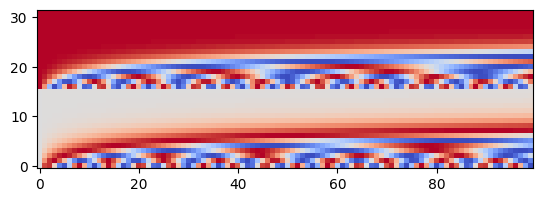

In [11]:
out = np.transpose(positionalencoding1d(32, 100))
plt.imshow(out, cmap="coolwarm", interpolation="nearest", origin="lower")
plt.show()

## The schedulers

In [5]:
import tensorflow as tf

2024-10-08 15:50:44.572952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 15:50:44.590285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 15:50:44.595991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 15:50:44.609972: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 15:50:45.871062: W tensorflow/compiler/tf2

In [6]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = tf.math.cumprod(alphas)
    signal_rates = tf.sqrt(alpha_bars)
    noise_rates = tf.sqrt(1 - alpha_bars)
    return noise_rates, signal_rates


def cosine_diffusion_schedule(diffusion_times):
    signal_rates = tf.cos(diffusion_times * math.pi / 2)
    noise_rates = tf.sin(diffusion_times * math.pi / 2)
    return noise_rates, signal_rates


def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates


2024-10-08 15:51:30.572514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 708 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:82:00.0, compute capability: 7.5
W0000 00:00:1728373890.666646 2466332 gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
W0000 00:00:1728373891.140506 2468098 gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
W0000 00:00:1728373891.144070 2468090 gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
W0000 00:00:1728373891.145584 2468102 gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
W0000 00:00:1728373891.155370 2468091 gpu_kernel_to_blob_pass.cc:190] Failed to compile generated PTX with ptxas. Falling back to compi

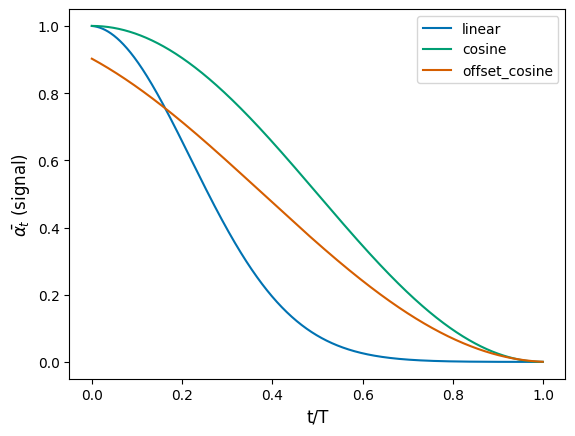

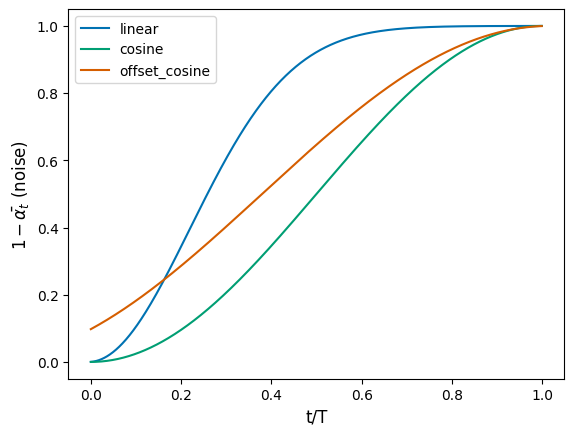

In [7]:
T = 1000
diffusion_times = tf.convert_to_tensor([x / T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(
    diffusion_times
)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(
    diffusion_times
)
(
    offset_cosine_noise_rates,
    offset_cosine_signal_rates,
) = offset_cosine_diffusion_schedule(diffusion_times)


plt.plot(
    diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_signal_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()


plt.plot(
    diffusion_times, linear_noise_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_noise_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_noise_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize=12)
plt.legend()
plt.show()